In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/2024_1.csv', encoding='euc-kr')

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

print(data.head())
# Define split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Split the data into training, validation, and testing sets
train_data, temp_data = train_test_split(data, test_size=(1 - train_ratio))
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio))

# Save the splits to CSV files if needed
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

     관측지점              관측시간  관측온도  관측습도    관측기압  관측풍속   관측풍향  관측최대풍속  관측미세먼지  \
0   예산_주거  2024-01-03 23:10   0.0  83.8  1019.2   0.2  310.7     0.8    41.8   
1   청주_주거  2024-01-26 20:10  -0.6  73.4  1021.6   0.2   58.5     0.4    71.0   
2  인천_주거2  2024-01-23 13:40  -9.5  51.4  1026.0   1.2  330.9     3.9    17.0   
3  충주_주거1  2024-01-08 11:20  -3.5  48.9  1016.5   0.7  276.6     1.5    16.0   
4   세종_도시  2024-01-13 06:30  -3.0  71.9  1015.9   0.1  353.1     0.5    29.1   

   관측초미세먼지  ...  (AVOC)배관관측온도  (BVOC)관측온도  (BVOC)관측습도  (BVOC)관측기압  (BVOC)관측풍속  \
0     39.0  ...         103.7        -0.2        84.2      1019.2         0.3   
1     62.6  ...         104.5        -0.6        73.3      1021.6         0.2   
2     12.6  ...         106.3        -9.5        51.6      1025.9         1.3   
3     12.5  ...         107.9        -3.6        49.0      1016.6         0.7   
4     20.9  ...         101.1        -3.0        72.1      1016.0         0.2   

   (BVOC)관측풍향  (BVOC)관측최대풍속  (BV

# **MLP test1, lr = 0.001 and 300 epoch**

Epoch [1/300], Loss: 202.5556, Test Loss: 26.3067
Epoch [2/300], Loss: 41.5825, Test Loss: 9.8136
Epoch [3/300], Loss: 30.6429, Test Loss: 9.1648
Epoch [4/300], Loss: 27.5994, Test Loss: 9.3529
Epoch [5/300], Loss: 26.8370, Test Loss: 8.7244
Epoch [6/300], Loss: 26.6340, Test Loss: 8.7742
Epoch [7/300], Loss: 27.1397, Test Loss: 8.1595
Epoch [8/300], Loss: 25.3927, Test Loss: 9.8308
Epoch [9/300], Loss: 24.0672, Test Loss: 7.8979
Epoch [10/300], Loss: 23.8733, Test Loss: 7.8510
Epoch [11/300], Loss: 22.7175, Test Loss: 9.6344
Epoch [12/300], Loss: 22.4831, Test Loss: 8.1040
Epoch [13/300], Loss: 21.7372, Test Loss: 7.8434
Epoch [14/300], Loss: 22.2847, Test Loss: 8.1698
Epoch [15/300], Loss: 21.8390, Test Loss: 8.2337
Epoch [16/300], Loss: 21.1057, Test Loss: 7.5006
Epoch [17/300], Loss: 21.1577, Test Loss: 8.3742
Epoch [18/300], Loss: 20.2343, Test Loss: 8.0053
Epoch [19/300], Loss: 19.7358, Test Loss: 9.9028
Epoch [20/300], Loss: 20.7914, Test Loss: 7.4361
Epoch [21/300], Loss: 19.63

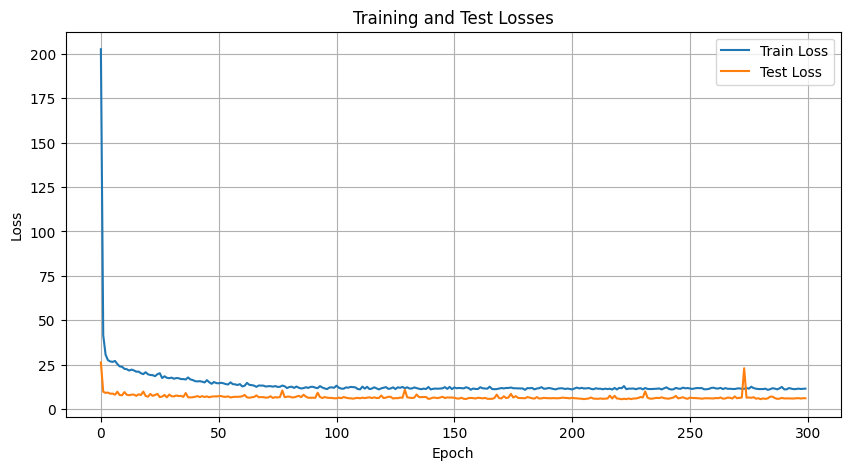

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#CPU 혹은 GPU 사용, GPU우선적으로 사용가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
# 이전의 전러치 코드에서 저장한 데이터 사용, val_data는  아마 eval에서 사용예정
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제,추후 필요없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "관측지점", "관측시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지", "관측지점", "관측시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 데이터셋 축소, 시연에서는 10%만 사용, 이후에는 숫자만 조정으로 데이터사이즈 조정,
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=0.1, random_state=42)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)



# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2) #overfiting 방지를 위한 drop

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    #현재는 미세먼지 농도 "수치"를 예측하는것인 모델이고
    #"수치"를 또 분류하려면 layer를 추가하면됨 ex)softmax(다중분류  ex:저 중 고) , binary(이진분류 ex:저 고)


model = MLP()

# 손실 함수, 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   # 0.01로 20인경우 5번째부터 verfiiting 발생  0.001에 epoch 20이 적당해보임

train_losses = []
test_losses = []
# 모델 학습
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Append training loss

    #모델 성능 임시 테스트용, 삭제해도 무관
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    test_losses.append(test_loss.item())  # Append test loss

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Loss: {test_loss.item():.4f}')

# Plotting training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(True)
plt.show()


# 예측 함수 정의
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    return y_pred.numpy()

# 예측후 결과 저장
predicted_values = predict(model, X_test)

#결과를 npy값으로 저장, 다음파일에서 사용가능
np.save('MLP.npy', predicted_values)

# **MLP test1, lr = 0.01 and 300 epoch**

Epoch [1/300], Loss: 88.2575, Test Loss: 10.8607
Epoch [2/300], Loss: 45.5852, Test Loss: 11.1892
Epoch [3/300], Loss: 39.9106, Test Loss: 10.1118
Epoch [4/300], Loss: 32.0028, Test Loss: 14.4048
Epoch [5/300], Loss: 31.6311, Test Loss: 12.9310
Epoch [6/300], Loss: 28.8189, Test Loss: 9.2001
Epoch [7/300], Loss: 24.4543, Test Loss: 10.2919
Epoch [8/300], Loss: 26.8531, Test Loss: 7.4008
Epoch [9/300], Loss: 25.2182, Test Loss: 10.9018
Epoch [10/300], Loss: 22.1211, Test Loss: 6.4596
Epoch [11/300], Loss: 21.4469, Test Loss: 13.7887
Epoch [12/300], Loss: 43.2604, Test Loss: 4.7556
Epoch [13/300], Loss: 26.7996, Test Loss: 14.1906
Epoch [14/300], Loss: 22.7088, Test Loss: 11.8287
Epoch [15/300], Loss: 24.9268, Test Loss: 1.7668
Epoch [16/300], Loss: 21.2377, Test Loss: 10.0835
Epoch [17/300], Loss: 29.8721, Test Loss: 7.7918
Epoch [18/300], Loss: 22.4775, Test Loss: 6.9400
Epoch [19/300], Loss: 20.4484, Test Loss: 11.0444
Epoch [20/300], Loss: 24.5897, Test Loss: 5.2287
Epoch [21/300], L

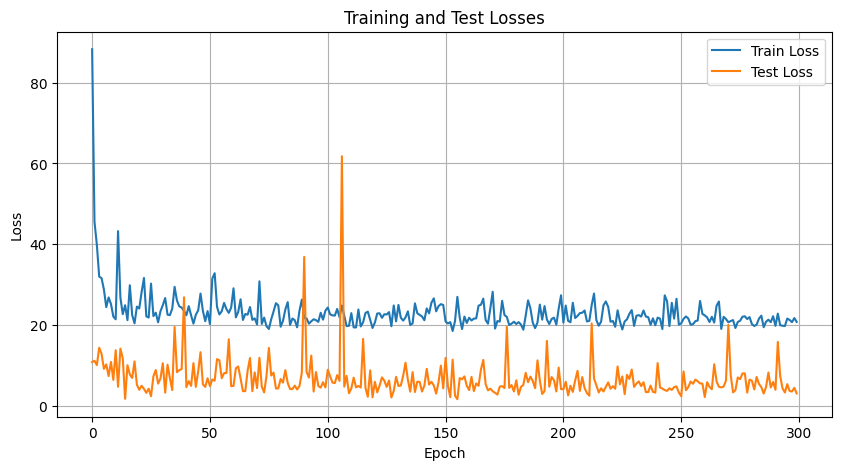

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#CPU 혹은 GPU 사용, GPU우선적으로 사용가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기 (전처리 완료된 데이터라고 가정)
# 이전의 전러치 코드에서 저장한 데이터 사용, val_data는  아마 eval에서 사용예정
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제,추후 필요없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "관측지점", "관측시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지", "관측지점", "관측시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 데이터셋 축소, 시연에서는 10%만 사용, 이후에는 숫자만 조정으로 데이터사이즈 조정,
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=0.1, random_state=42)

# Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)



# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2) #overfiting 방지를 위한 drop

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    #현재는 미세먼지 농도 "수치"를 예측하는것인 모델이고
    #"수치"를 또 분류하려면 layer를 추가하면됨 ex)softmax(다중분류  ex:저 중 고) , binary(이진분류 ex:저 고)


model = MLP()

# 손실 함수, 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)   # 0.01로 20인경우 5번째부터 verfiiting 발생  0.001에 epoch 20이 적당해보임

train_losses = []
test_losses = []
# 모델 학습
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Append training loss

    #모델 성능 임시 테스트용, 삭제해도 무관
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    test_losses.append(test_loss.item())  # Append test loss

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Loss: {test_loss.item():.4f}')

# Plotting training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(True)
plt.show()


# 예측 함수 정의
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    return y_pred.numpy()

# 예측후 결과 저장
predicted_values = predict(model, X_test)

#결과를 npy값으로 저장, 다음파일에서 사용가능
np.save('MLP.npy', predicted_values)